In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import pickle
from scipy.signal import butter, lfilter, find_peaks_cwt, find_peaks, periodogram
from scipy.stats import kurtosis, skew
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler


import random
import os

# preprocessing
first we are going to start with loading the data with pickle and then 
we will start normalizing our data

In [2]:
seed = 57

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

x = pickle.load(open('x.pkl', 'rb'))
y = pickle.load(open('y.pkl', 'rb'))

x_normal = np.concatenate((x[:300], x[400:]), axis=0)
x_seizure = x[300:400]
print(x_normal.shape)
print(x_seizure.shape)
sampling_freq = 173.6  # based on info from website

b, a = butter(3, [0.5, 40], btype='bandpass', fs=sampling_freq)

x_normal_filtered = np.array([lfilter(b, a, x_normal[ind, :]) for ind in range(x_normal.shape[0])])
x_seizure_filtered = np.array([lfilter(b, a, x_seizure[ind, :]) for ind in range(x_seizure.shape[0])])
print(x_normal.shape)
print(x_seizure.shape)

x_normal = x_normal_filtered
x_seizure = x_seizure_filtered

x = np.concatenate((x_normal, x_seizure))
y = np.concatenate((np.zeros((400, 1)), np.ones((100, 1))))

(400, 4097)
(100, 4097)
(400, 4097)
(100, 4097)


## show some signals 

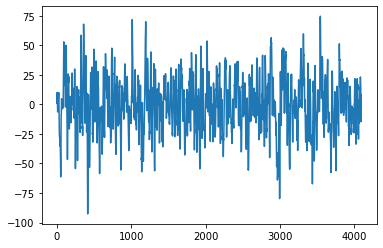

[0.]


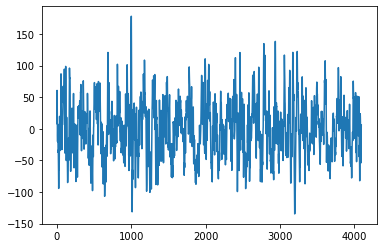

[0.]


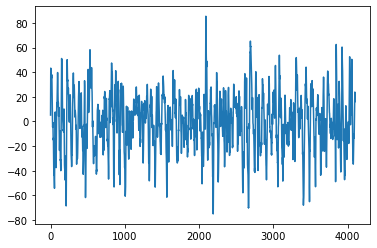

[0.]


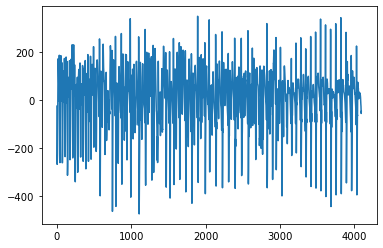

[1.]


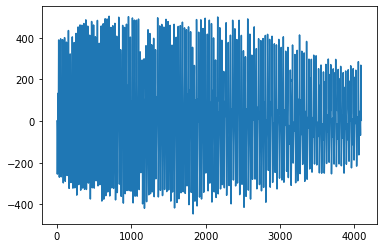

[1.]


In [3]:
# plot some of the signals and their y values
plt.plot(x[0])
plt.show()
print(y[0])
plt.plot(x[1])
plt.show()
print(y[1])
plt.plot(x[2])
plt.show()
print(y[2])
plt.plot(x[-1])
plt.show()
print(y[-1])
plt.plot(x[-2])
plt.show()
print(y[-2])

# Statistical analysis
we will start with statistical analysis of our data and then we will
start with the visualization of our data
our statistical analysis will be done with the help of numpy
our statistical data are:
1. mean: mean of our data
2. median: median of our data
3. max: maximum value of our data
4. min: minimum value of our data
5. std: standard deviation of our data
6. var: variance of our data the formula is: var = std^2
7. skew: skewness of our data the formula is: skew = (mean - median)/std
8. kurtosis: kurtosis of our data the formula is: kurtosis = (mean - median)^2/var

### what is skewness and kurtosis?
skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive or negative, or even undefined. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point. A distribution is skewed to the right if it is longer on the right side of the center point than on the left side. A distribution is skewed to the left if it is longer on the left side of the center point than on the right side. Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.

In [4]:
var = np.var(x, axis=1)
mean = np.mean(x, axis=1)
max = np.max(x, axis=1)
min = np.min(x, axis=1)
median = np.median(x, axis=1)
std = np.std(x, axis=1)
skew = np.array([skew(x[ind, :]) for ind in range(x.shape[0])])
kurtosis = np.array([kurtosis(x[ind, :]) for ind in range(x.shape[0])])

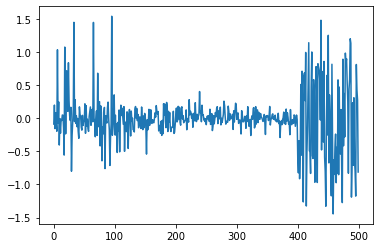

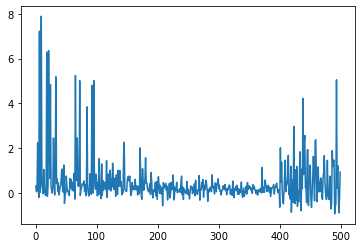

In [5]:
plt.plot(skew)
plt.show()
plt.plot(kurtosis)
plt.show()

In [6]:
var.shape

(500,)

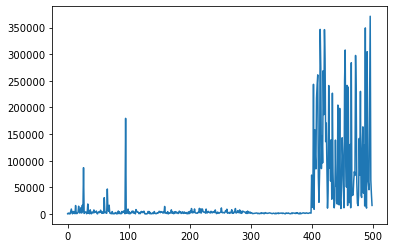

In [7]:
plt.plot(var)

### building our new x based on the statistical data features that we have calculated

In [8]:
# add the new features to the dataset
newX = np.concatenate((var.reshape(-1, 1), mean.reshape(-1, 1), max.reshape(-1, 1), min.reshape(-1, 1),
                        median.reshape(-1, 1), std.reshape(-1, 1)), axis=1)
newX.shape

(500, 6)

#### splitting our data into train and test

In [9]:
x_train, x_test, y_train, y_test = train_test_split(newX, y, random_state=seed, test_size=0.2)

### building our model with SVC which is Support Vector Classifier and then we will train our model

In [10]:
clf = SVC(kernel='linear', max_iter=20000000)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(accuracy_score(y_test, y_pred))

c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.96


c:\Users\alast\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


### Entropy is proportional to the degree of disorder in a thermodynamic process; the higher the degree of disorder, the higher the entropy.

In [11]:
def entropy(signal):
    '''
    function returns entropy of a signal
    signal must be a 1-D numpy array
    '''
    lensig=signal.size
    symset=list(set(signal))
    numsym=len(symset)
    propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
    ent=np.sum([p*np.log2(1.0/p) for p in propab])
    return ent

In [12]:
# calculate entropy for each signal
ent = np.array([entropy(x[ind, :]) for ind in range(x.shape[0])])
ent.shape

(500,)

#### as you can see below entropy is not a good feature for our data

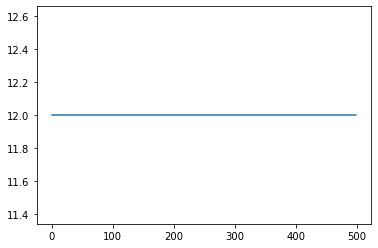

In [13]:
plt.plot(ent)

### what is fft?
fft is a fast fourier transform which is a mathematical tool that is used to convert a signal from its original domain (time) to a representation in the frequency domain and vice versa.

In [14]:
res_fft = np.fft.fftshift(np.fft.fft(x))

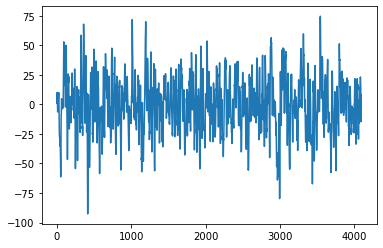

c:\Users\alast\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


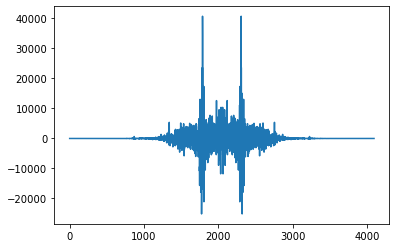

In [15]:
plt.plot(x[0])
plt.show()
plt.plot(res_fft[0])

In [16]:
fft_abs = np.abs(res_fft)
fft_mean = np.mean(fft_abs, axis=1)
fft_var = np.var(fft_abs, axis=1)

In [17]:
fft_mean.shape

(500,)

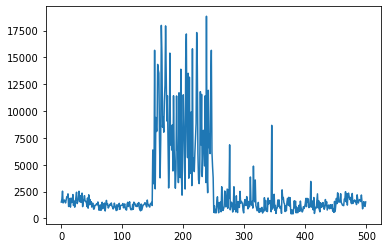

In [18]:
plt.plot(fft_mean)

In [19]:
newX = np.concatenate((fft_mean.reshape(-1, 1), fft_var.reshape(-1, 1)), axis=1)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(newX, y, random_state=seed, test_size=0.2)

In [21]:
clf = SVC(kernel='linear', max_iter=2000000, random_state=seed)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(accuracy_score(y_test, y_pred))

c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.74


c:\Users\alast\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [22]:
fft = np.fft.fft(x)
fft_abs = np.abs(fft)
fft_mean = np.mean(fft_abs, axis=1)
fft_var = np.var(fft_abs, axis=1)

c:\Users\alast\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


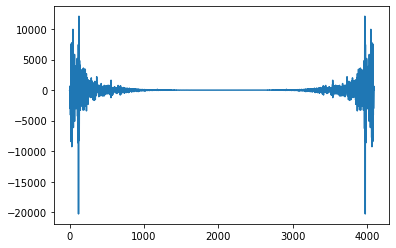

In [23]:
plt.plot(fft[0])

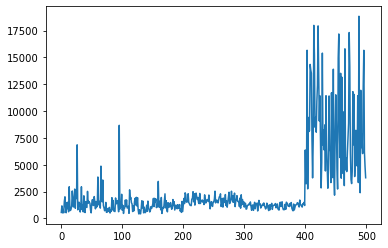

In [24]:
plt.plot(fft_mean)

In [25]:
freq = np.fft.fft2(x)
freq_abs = np.abs(freq)
freq_abs

array([[54299.3099113 , 56306.14656785, 62319.21483473, ...,
        61169.92142702, 62319.21483473, 56306.14656785],
       [77033.74284452, 80118.71234262, 83820.11809455, ...,
        60653.10006775, 72677.3143124 , 74167.29421778],
       [79155.72915375, 77318.13833529, 76462.75914202, ...,
        87891.13522609, 86198.81371291, 81358.96644186],
       ...,
       [56836.35042754, 58481.36781431, 60694.28326668, ...,
        50488.85907326, 55316.25427748, 55394.66118898],
       [79155.72915375, 81358.96644186, 86198.81371291, ...,
        72539.56763379, 76462.75914202, 77318.13833529],
       [77033.74284452, 74167.29421778, 72677.3143124 , ...,
        90708.11642632, 83820.11809455, 80118.71234262]])

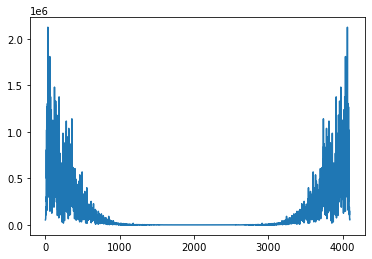

In [26]:
plt.plot(freq_abs[0])


In [27]:
freq_mean = np.mean(freq_abs, axis=1)
freq_var = np.var(freq_abs, axis=1)

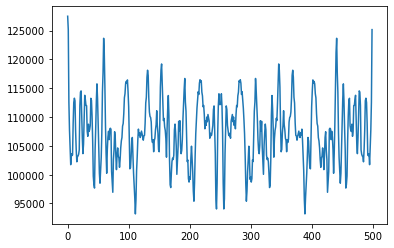

In [28]:
plt.plot(freq_mean)

In [29]:
newX = np.concatenate((freq_mean.reshape(-1, 1), freq_var.reshape(-1, 1)), axis=1)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(newX, y, random_state=seed, test_size=0.2)

##### difference  between fft and fft2 is that fft2 is used for 2d data and fft is used for 1d data

### this is the result of fft and works well with our data

In [31]:
clf = SVC(kernel='linear', max_iter=2000000, random_state=seed)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(accuracy_score(y_test, y_pred))

c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.73


c:\Users\alast\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


### calculating energy of signals and then we will use it as a feature
this is a good feature for our data as you can see below

In [32]:
#calculate the energy of each signal
energy = np.sum(x**2, axis=1)
energy.shape

(500,)

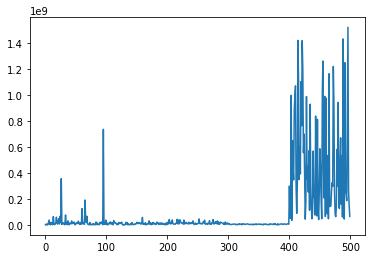

In [33]:
plt.plot(energy)

### calculating the power spectral density for each signal
what is power spectral density? power spectral density is the power per unit frequency of a signal. it is a measure of the power contained in a signal at different frequencies. it is a measure of the energy of a signal per unit frequency.

In [34]:
# calculate power spectral density for each signal
psd = np.array([periodogram(x[ind, :])[1] for ind in range(x.shape[0])])
psd.shape

(500, 2049)

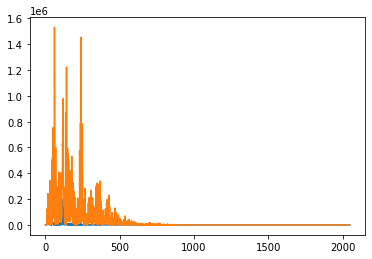

In [35]:
plt.plot(psd[0])
plt.plot(psd[-1])

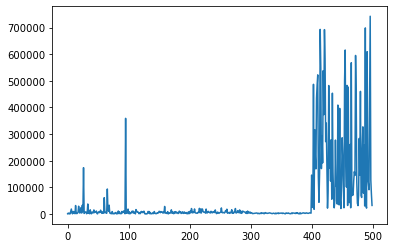

In [36]:
# now we can calculate the power spectral density for all signals
psd_mean = np.mean(psd, axis=1)
psd_var = np.var(psd, axis=1)
plt.plot(psd_mean)

### calculating the zero crossing rate for each signal
what is zero crossing rate? zero crossing rate is the rate at which a signal changes from positive to negative or vice versa. it is a measure of the number of times a signal changes from positive to negative or vice versa in a given time period.

In [37]:
# calculate zero crossing rate for each signal by our own 
def zero_crossing_rate(signal):
    '''
    function returns zero crossing rate of a signal
    signal must be a 1-D numpy array
    '''
    count = np.sum(np.abs(np.diff(np.sign(signal))))
    return count
# calculate zero crossing rate for each signal
zcr = np.array([zero_crossing_rate(x[ind, :]) for ind in range(x.shape[0])])
zcr.shape

(500,)

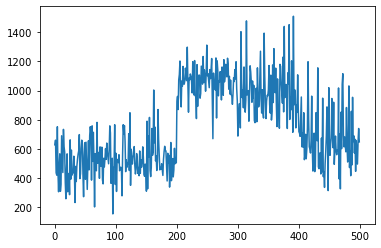

In [38]:
plt.plot(zcr)

### LBP is a local operator that is used to extract texture features from an image. it is a type of visual descriptor used for classification in computer vision.

In [39]:
#create local binary patterns function
def local_binary_pattern(x, n_points, radius, method='uniform'):
    '''
    function returns local binary pattern of a signal
    signal must be a 1-D numpy array
    n_points is the number of points to be considered as neighbourers
    radius is the radius of circle
    method is the type of LBP
    '''
    #get the number of samples in the signal
    n_samples = len(x)
    #create empty numpy array for the output LBP of the signal
    lbp = np.zeros(n_samples - 2 * radius)
    #loop over all the samples in the signal
    for i in range(radius, n_samples - radius):
        #get the center value of the signal
        center = x[i]
        #get the values of the neighbours
        val_neighbours = x[i - radius:i + radius + 1]
        #get the LBP code
        code = 0
        for j, val in enumerate(val_neighbours):
            if j != radius:
                if val >= center:
                    code += 1
                code = code << 1
        #remove the last bit
        code = code >> 1
        #set the code in the LBP image
        lbp[i - radius] = code
    return lbp

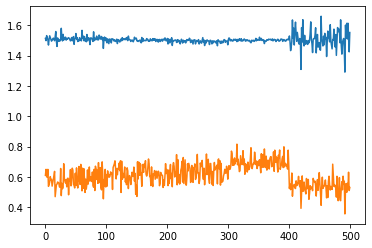

In [40]:
#LBP features
lbp = np.array([local_binary_pattern(x[ind, :], 8, 1, method='uniform') for ind in range(x.shape[0])])
lbp_mean = np.mean(lbp, axis=1)
lbp_var = np.var(lbp, axis=1)
plt.plot(lbp_mean)
plt.plot(lbp_var)

In [41]:
# this feature is the number of ups and downs => code
ups = np.sum(np.diff(np.sign(x)) != 0, axis=1) / 2
ups.shape

(500,)

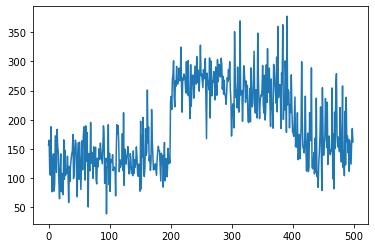

In [42]:
plt.plot(ups)

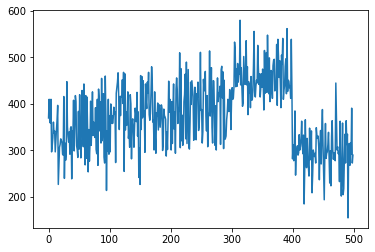

In [43]:
#detect peaks
peaks = np.array([find_peaks(x[ind, :])[0].shape[0] for ind in range(x.shape[0])])
plt.plot(peaks)

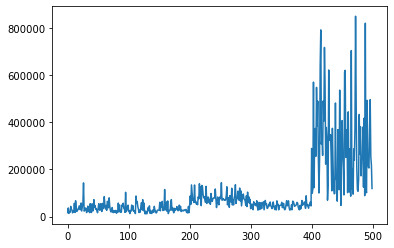

In [44]:
#calculate complexity
complexity = np.array([np.sum(np.abs(np.diff(x[ind, :]))) for ind in range(x.shape[0])])
plt.plot(complexity)

In [45]:
newX = np.concatenate((var.reshape(-1, 1), mean.reshape(-1, 1), max.reshape(-1, 1), min.reshape(-1, 1),
                           median.reshape(-1, 1), std.reshape(-1, 1), 
                           freq_mean.reshape(-1, 1), freq_var.reshape(-1, 1)), axis=1)
x_train, x_test, y_train, y_test = train_test_split(newX, y, random_state=seed, test_size=0.2)

In [46]:
newX = np.concatenate((var.reshape(-1, 1), mean.reshape(-1, 1), max.reshape(-1, 1), min.reshape(-1, 1),
                           median.reshape(-1, 1), std.reshape(-1, 1), 
                           freq_mean.reshape(-1, 1), freq_var.reshape(-1, 1), lbp_mean.reshape(-1, 1), lbp_var.reshape(-1, 1),
                           fft_mean.reshape(-1, 1), fft_var.reshape(-1, 1), peaks.reshape(-1, 1)), axis=1)
x_train, x_test, y_train, y_test = train_test_split(newX, y, random_state=seed, test_size=0.2)

#### best features for our data

In [47]:
newX = np.concatenate((var.reshape(-1, 1), mean.reshape(-1, 1), max.reshape(-1, 1), min.reshape(-1, 1),
                           median.reshape(-1, 1), std.reshape(-1, 1), lbp_mean.reshape(-1, 1), lbp_var.reshape(-1, 1),
                           fft_mean.reshape(-1, 1), fft_var.reshape(-1, 1), peaks.reshape(-1, 1), energy.reshape(-1, 1), psd_mean.reshape(-1, 1), psd_var.reshape(-1, 1), complexity.reshape(-1, 1)), axis=1)
x_train, x_test, y_train, y_test = train_test_split(newX, y, random_state=seed, test_size=0.2)
newX.shape
print(newX)


[[ 5.20426250e+02 -4.10541852e-03  7.46880989e+01 ...  1.04059851e+03
   3.95489006e+07  1.66763827e+04]
 [ 1.89970269e+03 -7.79047666e-02  1.78154673e+02 ...  3.79847825e+03
   2.99706054e+08  3.63143311e+04]
 [ 5.31121467e+02  5.08492028e-02  8.55170956e+01 ...  1.06198372e+03
   4.46759630e+07  1.34731616e+04]
 ...
 [ 6.39156750e+04 -2.09154790e-01  6.96188961e+02 ...  1.27800156e+05
   7.32128464e+11  2.54090735e+05]
 [ 3.71193449e+04  2.83596441e-01  5.03299972e+02 ...  7.42205739e+04
   2.06705085e+11  2.17483612e+05]
 [ 1.62138584e+04 -9.28565554e-02  3.50871506e+02 ...  3.24198037e+04
   1.12623183e+10  1.18912754e+05]]


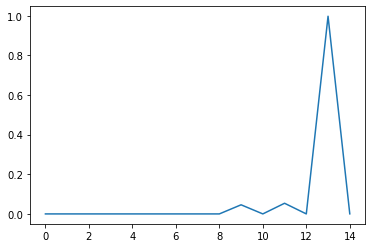

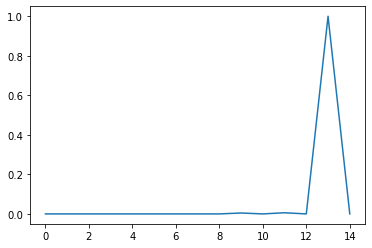

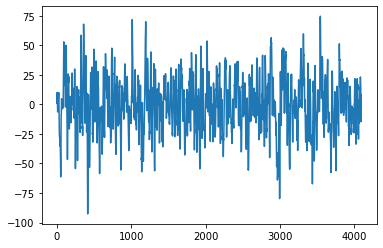

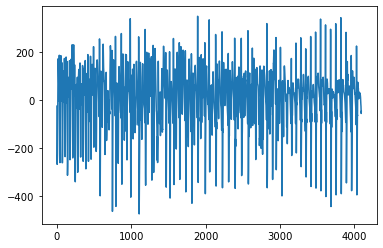

In [48]:
NormalizednewX = normalize(newX)
plt.plot(NormalizednewX[0])
plt.show()
plt.plot(NormalizednewX[-1])
plt.show()
plt.plot(x[0])
plt.show()
plt.plot(x[-1])
plt.show()

In [49]:
# another way to normalize data
# scaler = StandardScaler()
# scaler.fit(newX)
# newX.shape
# print(newX)

In [50]:
# another way to normalize data by our own
def normalize(x):
    '''
    function returns normalized signal
    signal must be a 1-D numpy array
    '''
    return (x - np.mean(x)) / np.std(x)

### using RANDOM FOREST CLASSIFIER to train our model
##### n_estimators:
The number of trees in the forest.
##### max_depth:
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
##### min_samples_split:
The minimum number of samples required to split an internal node: If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
##### random_state:
Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features). See Glossary for details.


In [51]:
custom_clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)
x_train.shape

<ipython-input-51-718cbd9d2049>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  custom_clf.fit(x_train, y_train)


(400, 15)

In [52]:
accuracy_score(y_test, y_pred)

0.98

In [53]:
recall_score(y_test, y_pred)

0.9230769230769231

In [54]:
precision_score(y_test, y_pred)

1.0

### k-fold cross validation
k-fold cross validation is a technique that is used to evaluate the performance of a model on a dataset. it is a resampling procedure that is used to evaluate machine learning models on a limited data sample. the procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. as such, the procedure is often called k-fold cross-validation. when a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
}
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
results = cross_validate(estimator=custom_clf, X=newX, y=y, cv=kfold, scoring=scoring)
results

In [55]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
}
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
results = cross_validate(estimator=custom_clf, X=newX, y=y, cv=kfold, scoring=scoring)
results

c:\Users\alast\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

{'fit_time': array([0.21120644, 0.2004962 , 0.19535494, 0.19682312, 0.16940546]),
 'score_time': array([0.01609492, 0.01918077, 0.02174854, 0.01867533, 0.01745844]),
 'test_accuracy': array([0.97, 0.95, 0.98, 0.97, 0.97]),
 'test_recall': array([0.88461538, 1.        , 0.95652174, 0.92857143, 1.        ]),
 'test_precision': array([1.        , 0.7826087 , 0.95652174, 0.86666667, 0.86363636]),
 'test_f1': array([0.93877551, 0.87804878, 0.95652174, 0.89655172, 0.92682927])}

In [56]:
scores = cross_val_score(custom_clf, newX, y, cv=5)
print("k-fold cross validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

c:\Users\alast\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

k-fold cross validation accuracy: 0.97 (+/- 0.07)


c:\Users\alast\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


### what is roc curve?
roc curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. the roc curve is created by plotting the true positive rate (tpr) against the false positive rate (fpr) at various threshold settings.

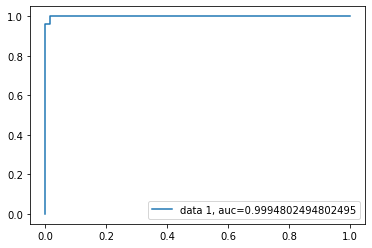

In [57]:
#roc plot
y_pred_proba = custom_clf.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

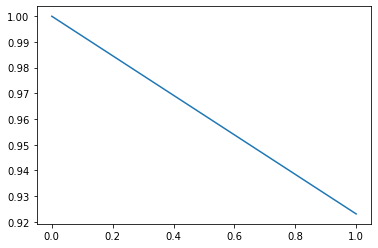

In [58]:
#recall plot
plt.plot(recall_score(y_test, y_pred, average=None))

### confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.
the square matrix is divided into four quadrants:
1. true positive (tp): these are cases in which we predicted yes (they have the disease), and they do have the disease.
2. true negative (tn): we predicted no, and they don't have the disease.
3. false positive (fp): we predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
4. false negative (fn): we predicted no, but they actually do have the disease. (Also known as a "Type II error.")

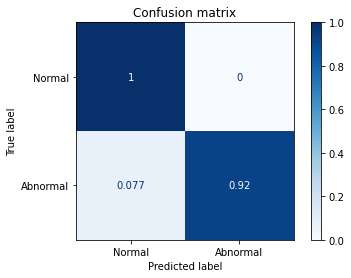

[[74  0]
 [ 2 24]]


In [59]:
#confusion matrix plot
disp = plot_confusion_matrix(custom_clf, x_test, y_test, display_labels=['Normal', 'Abnormal'], cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('Confusion matrix')
plt.show()
print(confusion_matrix(y_test, y_pred))

### now using KNeighborsClassifier
##### n_neighbors: n_neighbors is the number of neighbors that we are going to use to classify our data which here is 2
##### weights: weights is the weight function used in prediction. possible values are:
1. uniform: uniform weights. all points in each neighborhood are weighted equally.
2. distance : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
##### algorithm: which here is auto 

In [60]:
custom_clf = KNeighborsClassifier(n_neighbors=2, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)

c:\Users\alast\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### as you can see below kMeans is not a good model for our data and random forest is a good model for our data

In [61]:
accuracy_score(y_test, y_pred)

0.95

In [62]:
recall_score(y_test, y_pred)

0.8076923076923077

In [63]:
precision_score(y_test, y_pred)

1.0

#### normalization is not good for KNeighbors at all

In [64]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
}
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
results = cross_validate(estimator=custom_clf, X=newX, y=y, cv=kfold, scoring=scoring)
results

c:\Users\alast\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

{'fit_time': array([0.00328851, 0.00200033, 0.0019989 , 0.00151396, 0.00299454]),
 'score_time': array([0.00831795, 0.00654674, 0.00868464, 0.00651765, 0.00873256]),
 'test_accuracy': array([0.95, 0.94, 0.92, 0.91, 0.89]),
 'test_recall': array([0.80769231, 0.94444444, 0.82608696, 0.78571429, 0.78947368]),
 'test_precision': array([1.        , 0.77272727, 0.82608696, 0.64705882, 0.68181818]),
 'test_f1': array([0.89361702, 0.85      , 0.82608696, 0.70967742, 0.73170732])}

In [65]:
scores = cross_val_score(custom_clf, newX, y, cv=5)
print("=> k-fold cross validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

=> k-fold cross validation accuracy: 0.94 (+/- 0.07)


c:\Users\alast\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

### use SVM to train our model
kernel: kernel type to be used in the algorithm. it must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable. if none is given, 'rbf' will be used. if a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).

#### linear kernel is not a good model for our data

In [66]:
custom_clf = SVC(kernel='poly', max_iter=20000, C=1.0, random_state=0)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)

c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


#### the best and fastest kernel for our signal data is rbf kernel
now what is rbf kernel? rbf kernel is a radial basis function kernel which is a popular kernel function used in various kernelized learning algorithms. the rbf kernel is a stationary kernel. it is also known as the gaussian kernel. it is parameterized by a single parameter called gamma. the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. the gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

##### what is c in SVM? c is the penalty parameter of the error term. it controls the trade off between smooth decision boundary and classifying the training points correctly. a large c value gives low bias and high variance, while a small c value gives high bias and low variance.

In [67]:
standardscaler = StandardScaler()
normalizedX = standardscaler.fit_transform(newX) 
normalizedX.shape

(500, 15)

In [68]:
#make svc faster
custom_clf = SVC(kernel='rbf', max_iter=2000000000, C=10, random_state=0)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)
x_train.shape

c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(400, 15)

In [69]:
accuracy_score(y_test, y_pred)

0.93

In [70]:
recall_score(y_test, y_pred)

0.7307692307692307

In [71]:
precision_score(y_test, y_pred)

1.0

#### normalizing with standardScaler is good for here

In [72]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
}
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
results = cross_validate(estimator=custom_clf, X=normalizedX, y=y, cv=kfold, scoring=scoring)
results

c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

{'fit_time': array([0.00620294, 0.00477409, 0.00903845, 0.00934124, 0.00762987]),
 'score_time': array([0.00544143, 0.002002  , 0.        , 0.00672388, 0.00868797]),
 'test_accuracy': array([0.95, 0.96, 1.  , 0.98, 0.97]),
 'test_recall': array([0.80769231, 0.94444444, 1.        , 0.85714286, 0.94736842]),
 'test_precision': array([1.  , 0.85, 1.  , 1.  , 0.9 ]),
 'test_f1': array([0.89361702, 0.89473684, 1.        , 0.92307692, 0.92307692])}

In [73]:
scores = cross_val_score(custom_clf, newX, y, cv=5)
print(scores)
print("=> k-fold cross validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0.93 0.95 0.93 0.95 0.94]
=> k-fold cross validation accuracy: 0.94 (+/- 0.02)


c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\alast\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


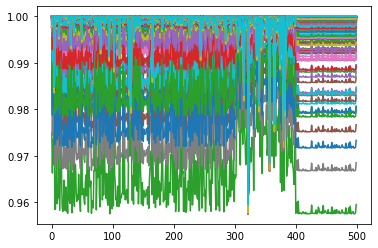

In [74]:
#calculate correlation of each feature and compare it with other features
corr = np.corrcoef(newX)
#plot all features to get an idea of how they are correlated
plt.plot(corr)

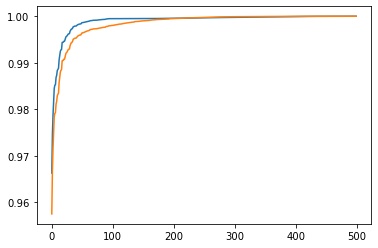

In [75]:
#compare each feature correlation with other features correlation and sort them 
#to get the most correlated features
corr = np.abs(corr)
corr = np.sort(corr, axis=1)
plt.plot(corr[1])
plt.plot(corr[-4])

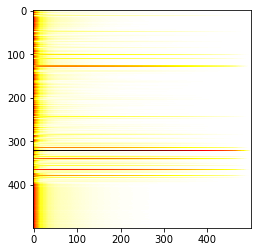

In [76]:
#make heat map of correlation
plt.imshow(corr, cmap='hot', interpolation='nearest')
plt.show()

In [77]:
#import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

In [78]:
#classify data with each feature with decision tree
best_features = []
for i in range(0, newX.shape[1]):
    x_train, x_test, y_train, y_test = train_test_split(newX[:,i].reshape(-1, 1), y, test_size=0.2, random_state=seed)
    custom_clf = DecisionTreeClassifier(random_state=0)
    custom_clf.fit(x_train, y_train)
    y_pred = custom_clf.predict(x_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_precision = precision_score(y_test, y_pred)
    print('feature', i, '(accuracy, recall, precision):', model_accuracy, model_recall, model_precision)
    if model_accuracy > 0.8 and model_recall > 0.7 and model_precision > 0.8:
        best_features.append(i)
#this attribute is for our decremental algorithm        
new_optimizedX = newX[:,best_features]
#this attribute is for our incremental algorithm
filtered_features = newX[:, best_features]
new_optimizedX.shape

feature 0 (accuracy, recall, precision): 0.96 0.8461538461538461 1.0
feature 1 (accuracy, recall, precision): 0.71 0.2692307692307692 0.4117647058823529
feature 2 (accuracy, recall, precision): 0.94 0.8076923076923077 0.9545454545454546
feature 3 (accuracy, recall, precision): 0.96 0.8846153846153846 0.9583333333333334
feature 4 (accuracy, recall, precision): 0.97 0.8846153846153846 1.0
feature 5 (accuracy, recall, precision): 0.96 0.8461538461538461 1.0
feature 6 (accuracy, recall, precision): 0.75 0.2692307692307692 0.5384615384615384
feature 7 (accuracy, recall, precision): 0.73 0.3076923076923077 0.47058823529411764
feature 8 (accuracy, recall, precision): 0.96 0.8846153846153846 0.9583333333333334
feature 9 (accuracy, recall, precision): 0.95 0.8076923076923077 1.0
feature 10 (accuracy, recall, precision): 0.75 0.23076923076923078 0.5454545454545454
feature 11 (accuracy, recall, precision): 0.96 0.8461538461538461 1.0
feature 12 (accuracy, recall, precision): 0.96 0.84615384615384

(500, 11)

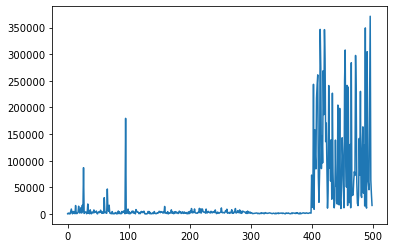

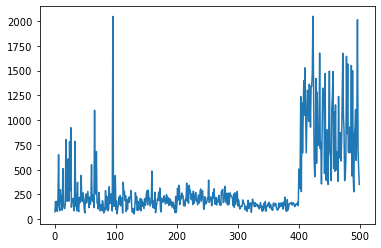

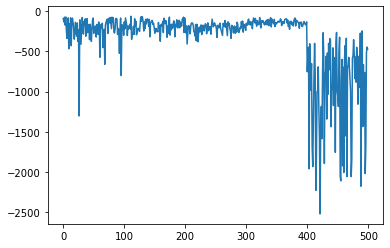

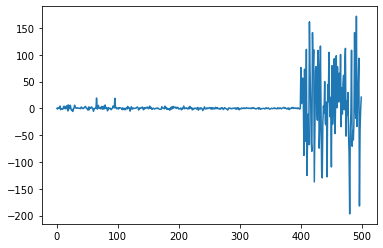

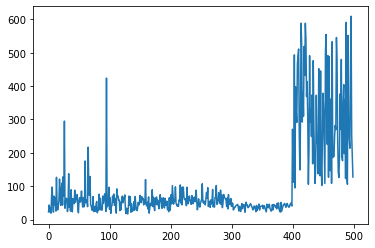

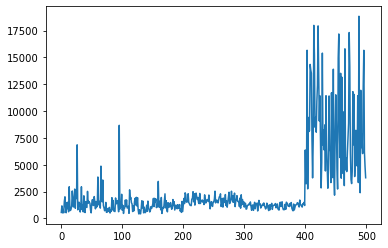

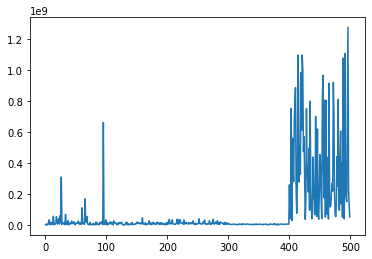

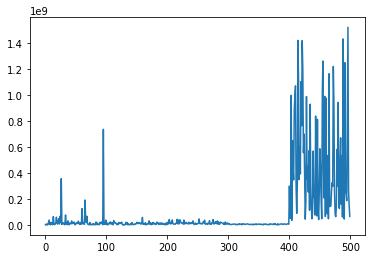

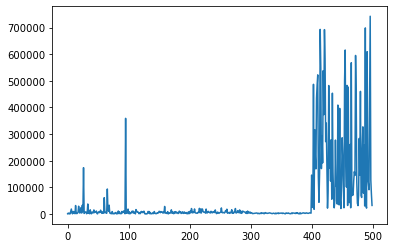

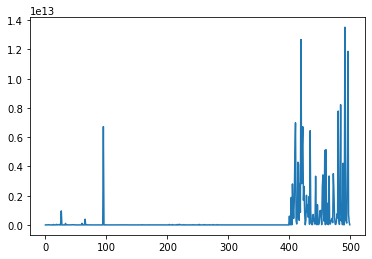

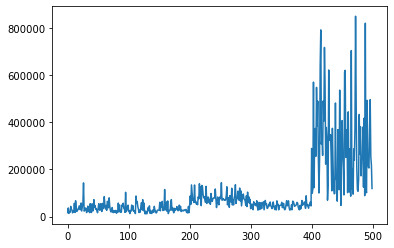

In [79]:
for feature in new_optimizedX.T:
    plt.plot(feature)
    plt.show()



### choose our features in decremental order

In [80]:
#loop in our new features
def get_best_features(new_optimizedX):
    the_best_features = []
    new_optimizedX_old = new_optimizedX
    decrease_value = 0
    for i in range(0, new_optimizedX_old.shape[1]):
        features_with_out_i = np.delete(new_optimizedX, i-decrease_value, axis=1)
        features_with_i = new_optimizedX[:,i-decrease_value].reshape(-1, 1)
        x_train, x_test, y_train, y_test = train_test_split(features_with_out_i, y, test_size=0.2, random_state=seed)
        custom_clf = DecisionTreeClassifier(random_state=0)
        custom_clf.fit(x_train, y_train)
        y_pred = custom_clf.predict(x_test)
        model_accuracy_with_out_i = accuracy_score(y_test, y_pred)
        model_recall_with_out_i = recall_score(y_test, y_pred)
        model_precision_with_out_i = precision_score(y_test, y_pred)
        # print('feature with out', i, '(accuracy, recall, precision):', model_accuracy, model_recall, model_precision)
        x_train, x_test, y_train, y_test = train_test_split(features_with_i, y, test_size=0.2, random_state=seed)
        custom_clf = DecisionTreeClassifier(random_state=0)
        custom_clf.fit(x_train, y_train)
        y_pred = custom_clf.predict(x_test)
        model_accuracy_with_i = accuracy_score(y_test, y_pred)
        model_recall_with_i = recall_score(y_test, y_pred)
        model_precision_with_i = precision_score(y_test, y_pred)
        # print('feature with', i, '(accuracy, recall, precision):', model_accuracy, model_recall, model_precision)
        if model_accuracy_with_i > model_accuracy_with_out_i and model_recall_with_i > model_recall_with_out_i and model_precision_with_i > model_precision_with_out_i:
            # print('feature', i, 'is important')
            the_best_features.append(i)
        # else:
        #     #delete feature i from new_optimizedX
        #     print('feature', i, 'is not important')
        #     new_optimizedX = np.delete(new_optimizedX, i-decrease_value, axis=1)
        #     print('new_optimizedX shape:', new_optimizedX.shape)
        #     decrease_value += 1
    return the_best_features

In [81]:
while True:
    best_features = get_best_features(new_optimizedX)
    if len(best_features) == 0:
        new_optimizedX = np.delete(new_optimizedX, 0, axis=1)
        if new_optimizedX.shape[1] == 0:
            break
        continue
    else:
        new_optimizedX = new_optimizedX[:,best_features]
        break

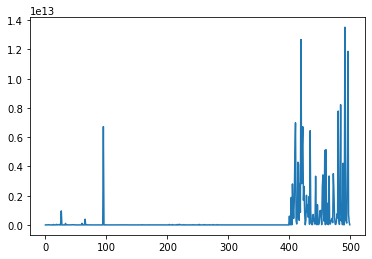

In [82]:
plt.plot(new_optimizedX)

### now lets get our features by an incremental algorithm

In [83]:
# first lets sort our features based on their f1 score with decision tree
sorted_features = []
index = 0
for feature in filtered_features.T:
    index += 1
    x_train, x_test, y_train, y_test = train_test_split(feature.reshape(-1, 1), y, test_size=0.2, random_state=seed)
    custom_clf = DecisionTreeClassifier(random_state=0)
    custom_clf.fit(x_train, y_train)
    y_pred = custom_clf.predict(x_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_precision = precision_score(y_test, y_pred)
    model_f1 = f1_score(y_test, y_pred)
    print('feature', index,'(accuracy, recall, precision, f1):', model_accuracy, model_recall, model_precision, model_f1)
    sorted_features.append((model_f1, feature))
sorted_features.sort(key=lambda x: x[0], reverse=True)
primary_features = np.array(sorted_features[0][1]).reshape(-1, 1)
sorted_features[0][0]

feature 1 (accuracy, recall, precision, f1): 0.96 0.8461538461538461 1.0 0.9166666666666666
feature 2 (accuracy, recall, precision, f1): 0.94 0.8076923076923077 0.9545454545454546 0.875
feature 3 (accuracy, recall, precision, f1): 0.96 0.8846153846153846 0.9583333333333334 0.9199999999999999
feature 4 (accuracy, recall, precision, f1): 0.97 0.8846153846153846 1.0 0.9387755102040816
feature 5 (accuracy, recall, precision, f1): 0.96 0.8461538461538461 1.0 0.9166666666666666
feature 6 (accuracy, recall, precision, f1): 0.96 0.8846153846153846 0.9583333333333334 0.9199999999999999
feature 7 (accuracy, recall, precision, f1): 0.95 0.8076923076923077 1.0 0.8936170212765957
feature 8 (accuracy, recall, precision, f1): 0.96 0.8461538461538461 1.0 0.9166666666666666
feature 9 (accuracy, recall, precision, f1): 0.96 0.8461538461538461 1.0 0.9166666666666666
feature 10 (accuracy, recall, precision, f1): 0.95 0.8076923076923077 1.0 0.8936170212765957
feature 11 (accuracy, recall, precision, f1): 0

0.9387755102040816

### we don't need to use the below block the best way is the way upside we found the best f1 score and we put it directly in primary_features

In [84]:
#now lets just train a model with our best feature and add features to it incremental 
custom_clf = DecisionTreeClassifier(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(sorted_features[0][1].reshape(-1, 1), y, test_size=0.2, random_state=0)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)
model_accuracy_old = accuracy_score(y_test, y_pred)
model_recall_old = recall_score(y_test, y_pred)
model_precision_old = precision_score(y_test, y_pred)
model_f1_old = f1_score(y_test, y_pred)
print('feature', i, '(accuracy, recall, precision, f1):', model_accuracy, model_recall, model_precision, model_f1)
primary_features = np.array(sorted_features[0][1].reshape(-1, 1))


feature 14 (accuracy, recall, precision, f1): 0.9 0.7307692307692307 0.8636363636363636 0.7916666666666666


### now lets add features to our primary features if they make our model precision and recall and f1 score better

In [85]:
def feature_has_correlation(selected_features):
    #our feature is the last item of selected feature
    feature = selected_features[:,-1]
    for selected_feature in selected_features.T:
        if np.corrcoef(feature, selected_feature)[0][1] > 0.5 or np.corrcoef(feature, selected_feature)[0][1] < -0.5:
            return True
    print('feature', feature, 'has no correlation', np.corrcoef(feature, selected_feature)[0][1])
    return False

In [86]:
len(sorted_features)

11

In [87]:
for feature in sorted_features[1:]:
    temp_primary_features = np.append(primary_features, feature[1].reshape(-1, 1), axis=1)
    x_train, x_test, y_train, y_test = train_test_split(np.array(temp_primary_features), y, test_size=0.25, random_state=0, shuffle=True)
    custom_clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    custom_clf.fit(x_train, y_train)
    y_pred = custom_clf.predict(x_test)
    model_f1 = f1_score(y_test, y_pred)
    if model_f1 >= model_f1_old and not feature_has_correlation(temp_primary_features):
        primary_features = temp_primary_features
        model_accuracy_old = model_accuracy
        model_recall_old = model_recall
        model_precision_old = model_precision
        model_f1_old = model_f1
        print('feature', i, 'is important')
primary_features.shape


<ipython-input-87-162a499910d1>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  custom_clf.fit(x_train, y_train)
<ipython-input-87-162a499910d1>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  custom_clf.fit(x_train, y_train)
<ipython-input-87-162a499910d1>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  custom_clf.fit(x_train, y_train)
<ipython-input-87-162a499910d1>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  custom_clf.fit(x_train, y_train)
<ipython-input-87-162a499910d1>:5: DataConversionWarning: A column-vector y was passed when a 1d arr

(500, 1)

### now lets check out our model accuracy with the new features

In [88]:
x_train, x_test, y_train, y_test = train_test_split(primary_features, y, test_size=0.2, random_state=seed)
custom_clf = DecisionTreeClassifier(random_state=0)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)
model_accuracy = accuracy_score(y_test, y_pred)
model_recall = recall_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred)
model_f1 = f1_score(y_test, y_pred)
print('feature', i, '(accuracy, recall, precision, f1):', model_accuracy, model_recall, model_precision, model_f1)

feature 14 (accuracy, recall, precision, f1): 0.97 0.8846153846153846 1.0 0.9387755102040816


### the way upside is not specificity what the project wanted but the way downside is

In [89]:
def calculate_accuracy_score(feature):
    x_train, x_test, y_train, y_test = train_test_split(feature.reshape(-1, 1), y, test_size=0.2, random_state=seed)
    custom_clf = DecisionTreeClassifier(random_state=0)
    custom_clf.fit(x_train, y_train)
    y_pred = custom_clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [113]:
def calculate_model_recall(feature):
    x_train, x_test, y_train, y_test = train_test_split(feature.reshape(-1, 1), y, test_size=0.2, random_state=seed)
    custom_clf = DecisionTreeClassifier(random_state=0)
    custom_clf.fit(x_train, y_train)
    y_pred = custom_clf.predict(x_test)
    recall = recall_score(y_test, y_pred, average='macro')
    return recall

### correlation with mean

In [90]:
def calculate_correlation(feature):
    #calculate correlation with all other features in newX and return the mean
    correlations = []
    for selected_feature in newX.T:
        correlations.append(np.corrcoef(feature, selected_feature)[0][1])
    return np.mean(correlations)

### correlation with max

In [112]:
def calculate_max_correlation(feature):
    #calculate correlation with all other features in newX and return the mean
    correlations = []
    for selected_feature in newX.T:
        correlations.append(np.corrcoef(feature, selected_feature)[0][1])
    return np.max(correlations)

In [114]:
# first we will calculate recall score of each feature then we will calculate the correlation of each feature with the other features
# then we will combine the two numbers (recall score and correlation) first we should normalize them and then we will combine them with formula like f1 score

features_with_custom_score = []
for feature in newX.T:
    accuracy = calculate_model_recall(feature)
    # print('recall score:', accuracy)
    correlation = calculate_max_correlation(feature)
    # print('correlation:', correlation)
    #normalize accuracy and correlation
    accuracy = accuracy / 1
    correlation = (correlation + 1) / 2
    #combine recall score and correlation like f1 score formula higher correlation will be bad for us and the correlation should be minimum 
    combined_score = (2 * accuracy * correlation) / (accuracy + correlation)
    # print('recall score:', accuracy, 'correlation:', correlation, 'combined score:', combined_score)
    features_with_custom_score.append((combined_score, feature))

sorted_features_with_custom_score = sorted(features_with_custom_score, key=lambda x: x[0], reverse=True)
#show the sorted features scores
for feature in sorted_features_with_custom_score:
    print(feature[0])

0.8790056321615848
0.8299209406040949
0.8047214744253468
0.8047214744253468
0.7992510921572707
0.7889215274863617
0.7822784810126583
0.7822784810126583
0.7822784810126583
0.7658755612572162
0.7589765641797462
0.6257142857142857
0.6244041944709247
0.5894428152492669
0.5765721331689273


In [115]:
#primary selected features are the features that have score more than 0.8
primary_selected_features = []
for feature in sorted_features_with_custom_score:
    if feature[0] > 0.8:
        primary_selected_features.append(feature[1])
    else:
        break

In [116]:
len(primary_selected_features)

4

In [117]:
primary_selected_features = np.array(primary_selected_features).T
primary_selected_features.shape

(500, 4)

# as you can see our model is awesome !


In [118]:
#cluster x with k-means
x_train, x_test, y_train, y_test = train_test_split(primary_selected_features, y, test_size=0.2, random_state=seed, shuffle=True)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=seed).fit(x_train)

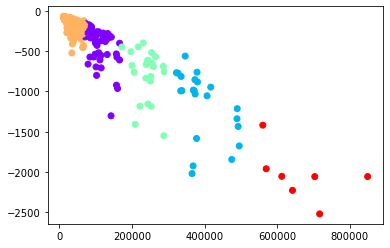

In [119]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=kmeans.labels_, cmap='rainbow')

In [120]:
#show each cluster number of data
for i in range(0, 5):
    print('cluster', i, 'number of data:', np.count_nonzero(kmeans.labels_ == i))
    

cluster 0 number of data: 75
cluster 1 number of data: 22
cluster 2 number of data: 22
cluster 3 number of data: 274
cluster 4 number of data: 7


### lets train each cluster 

In [121]:
#lets train each cluster with random forest classifier

cluster_model_clf = []
#loop in each cluster 
for cluster in range(0, 5):
    #get cluster data
    cluster_data = x_train[kmeans.labels_ == cluster]
    cluster_labels = y_train[kmeans.labels_ == cluster]
    #train random forest classifier
    custom_clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    custom_clf.fit(cluster_data, cluster_labels)
    cluster_model_clf.append(custom_clf)
    

In [123]:
#lets test our test data first we have to predict the cluster of each test data then we have to predict the label of each test data
y_pred = []
for test_data in x_test:
    #predict cluster
    cluster = kmeans.predict(test_data.reshape(1, -1))
    #predict label
    y_pred.append(cluster_model_clf[cluster[0]].predict(test_data.reshape(1, -1)))
y_pred = np.array(y_pred).reshape(-1, 1)
model_accuracy = accuracy_score(y_test, y_pred)
model_recall = recall_score(y_test, y_pred, average='macro')
model_precision = precision_score(y_test, y_pred, average='macro')
model_f1 = f1_score(y_test, y_pred, average='macro')
print('feature', i, '(accuracy, recall, precision, f1):', model_accuracy, model_recall, model_precision, model_f1)

feature 4 (accuracy, recall, precision, f1): 0.94 0.9421344421344422 0.9474969474969476 0.9419278513940044


### as you can see we have five types of data in y
* 0-100: is A and there are signals of normal people
* 100-200: is B and there are signals of normal people
* 200-300: is C and there are signals of normal people
* 300-400: is D and there are signals of normal people
* 400-500: is E and there are signals of seizure attack patients

#### now we have 3 types of three classes of data as below
* clf-type1 = A-B C-D
* clf-type2 = A-B E
* clf-type3 = C-D E
### and we have one type of two classes of data as below
* clf-type4 = A-B C-D E

In [124]:
#get the first 400 data of primary features and the first 400 and label first 200 are 0 and the last 200 are 1
primary_features = primary_features[:400]
y = y[:400]
y[:200] = 0
y[200:] = 1
#now we have a-b and c-d labels
#lets train a-b and c-d with random forest classifier
x_train, x_test, y_train, y_test = train_test_split(primary_features, y, test_size=0.2, random_state=seed, shuffle=True)
custom_clf = SVC(kernel='rbf', max_iter=2000000000, C=10 , random_state=0)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)
model_accuracy = accuracy_score(y_test, y_pred)
model_recall = recall_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred)
model_f1 = f1_score(y_test, y_pred)
print('feature', i, '(accuracy, recall, precision, f1):', model_accuracy, model_recall, model_precision, model_f1)

feature 4 (accuracy, recall, precision, f1): 0.5625 0.8571428571428571 0.5538461538461539 0.6728971962616823


In [125]:
def cluster_samples_and_classify_each_sample(x_train, y_train, x_test, y_test, n_clusters=5):
    #cluster x with k-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed).fit(x_train)
    #lets train each cluster with random forest classifier
    cluster_model_clf = []
    #loop in each cluster 
    for cluster in range(0, n_clusters):
        #get cluster data
        cluster_data = x_train[kmeans.labels_ == cluster]
        cluster_labels = y_train[kmeans.labels_ == cluster]
        #train random forest classifier
        custom_clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
        custom_clf.fit(cluster_data, cluster_labels)
        cluster_model_clf.append(custom_clf)
    #lets test our test data first we have to predict the cluster of each test data then we have to predict the label of each test data
    y_pred = []
    for test_data in x_test:
        #predict cluster
        cluster = kmeans.predict(test_data.reshape(1, -1))
        #predict label
        y_pred.append(cluster_model_clf[cluster[0]].predict(test_data.reshape(1, -1)))
    y_pred = np.array(y_pred).reshape(-1, 1)
    model_accuracy = accuracy_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred, average='macro')
    model_precision = precision_score(y_test, y_pred, average='macro')
    model_f1 = f1_score(y_test, y_pred, average='macro')
    return model_accuracy, model_recall, model_precision, model_f1

### a e

In [126]:
#our x is data 0-100 and 400-500 and y is 0-100 and 400-500 of primary selected features
x = np.concatenate((primary_selected_features[:100], primary_selected_features[400:500]))
y = np.concatenate((np.zeros(100), np.ones(100)))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, shuffle=True)
model_accuracy, model_recall, model_precision, model_f1 = cluster_samples_and_classify_each_sample(x_train, y_train, x_test, y_test, n_clusters=5)
print('feature', i, '(accuracy, recall, precision, f1):', model_accuracy, model_recall, model_precision, model_f1)

feature 4 (accuracy, recall, precision, f1): 1.0 1.0 1.0 1.0


### b e

In [127]:
#our x is data 100-200 and 400-500 and y is 100-200 and 400-500 of primary selected features
x = np.concatenate((primary_selected_features[100:200], primary_selected_features[400:500]))
y = np.concatenate((np.zeros(100), np.ones(100)))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, shuffle=True)
model_accuracy, model_recall, model_precision, model_f1 = cluster_samples_and_classify_each_sample(x_train, y_train, x_test, y_test, n_clusters=5)
print('feature', i, '(accuracy, recall, precision, f1):', model_accuracy, model_recall, model_precision, model_f1)

feature 4 (accuracy, recall, precision, f1): 0.975 0.96875 0.98 0.9736668861092824


### c e

In [128]:
#our x is data 200-300 and 400-500 and y is 200-300 and 400-500 of primary selected features
x = np.concatenate((primary_selected_features[200:300], primary_selected_features[400:500]))
y = np.concatenate((np.zeros(100), np.ones(100)))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, shuffle=True)
model_accuracy, model_recall, model_precision, model_f1 = cluster_samples_and_classify_each_sample(x_train, y_train, x_test, y_test, n_clusters=5)
print('feature', i, '(accuracy, recall, precision, f1):', model_accuracy, model_recall, model_precision, model_f1)

feature 4 (accuracy, recall, precision, f1): 0.975 0.9791666666666667 0.9705882352941176 0.9742101869761444


### three classes a-b c-d e

In [129]:
#our x is 0-200 200-400 and 400-500 and y is 0-200 200-400 and 400-500 of primary selected features y 0-200 is 0 and 200-400 is 1 and 400-500 is 2
x = np.concatenate((primary_selected_features[:200], primary_selected_features[200:400], primary_selected_features[400:500]))
y = np.concatenate((np.zeros(200), np.ones(200), np.ones(100)*2))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, shuffle=True)
model_accuracy, model_recall, model_precision, model_f1 = cluster_samples_and_classify_each_sample(x_train, y_train, x_test, y_test, n_clusters=5)
print('feature', i, '(accuracy, recall, precision, f1):', model_accuracy, model_recall, model_precision, model_f1)

feature 4 (accuracy, recall, precision, f1): 0.94 0.9421344421344422 0.9474969474969476 0.9419278513940044
